In [37]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt

import sys 
from nglview import show_ase, show_file, show_mdtraj
import torch
import torchmd

In [127]:
from ase.lattice.cubic import FaceCenteredCubic
from torchmd.interface import PairPotentials
from torchmd.system import System
from torchmd.potentials import  LennardJones
from nff.train import get_model

def get_system(rho, T, size, device, N_unitcell):
    L = (N_unitcell / rho) ** (1/3)
    atoms = FaceCenteredCubic(symbol='H',
                              size=(size, size, size),
                              latticeconstant=L,
                              pbc=True)

    from torchmd.system import System
    system = System(atoms, device=device)
    system.set_temperature(T)
    
    return system 

def get_simulator(system, T, diffeq):
    from torchmd.md import Simulations
    sim = Simulations(system, diffeq)
    
    return sim

In [128]:
from torchmd.md import NoseHooverChain 

In [132]:
# simulate LJ liquids 

from torchmd.observable import rdf, vacf
from torchmd.md import NoseHooverChain 

device = 'cpu'
repeat = 4
T = 1

system = get_system(0.8, T, repeat, device, N_unitcell=4)

# Define interaction terms 
pair = PairPotentials(system, 
                    LennardJones(**{'epsilon': 1.0, 'sigma': 1.0}),
                    cutoff=2.5,
                   ).to(system.device)


model = Stack({
                    'pair': pair
    })

integrator =NoseHooverChain(model, 
                system,
                Q=20.0, 
                T=T,
                num_chains=5, 
                adjoint=True).to(system.device)


sim = get_simulator(system, T, diffeq=integrator)

# Set up observable 
obs = rdf(system, nbins=100, r_range=(0.75, 3.3))
vacf_obs = vacf(system, t_range=60) 

The input temperature is 11604.522060401008 K if it is in electronic units 


In [118]:
v_t, q_t, pv_t = sim.simulate(steps=1000, frequency=5, dt=0.01)

In [119]:
# compute observable from the trajectory 
_, _, g_sim = obs(q_t)

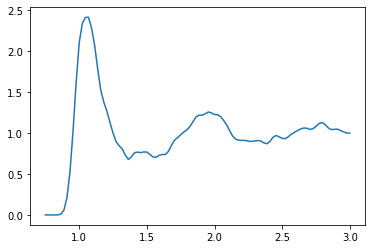

In [120]:
plt.plot(np.linspace(0.75, 3.0, 100), g_sim.detach().numpy())
plt.show()

In [121]:
# Check temperature 
from torchmd.thermo import Temperature

In [122]:
temp_calc = Temperature(system )
temp_traj = [temp_calc(torch.Tensor(vel)).item() for vel in sim.log['velocities']][50:]

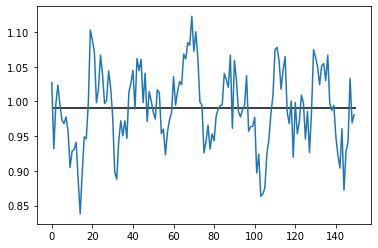

In [123]:
plt.plot(temp_traj)
plt.hlines(np.array(temp_traj).mean(), xmin=0, xmax=len(temp_traj))
plt.show()